In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
news_df = pd.read_csv('../data/data.csv')
# Extract keywords from titles and full content using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# Apply TF-IDF on titles
tfidf_matrix_titles = tfidf_vectorizer.fit_transform(news_df['title'].fillna(""))

# Apply TF-IDF on full content
tfidf_matrix_content = tfidf_vectorizer.fit_transform(news_df['full_content'].fillna(""))

# Convert to DataFrame for easier analysis
tfidf_titles_df = pd.DataFrame(tfidf_matrix_titles.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_content_df = pd.DataFrame(tfidf_matrix_content.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Example: Find top keywords in titles
top_keywords_titles = tfidf_titles_df.sum().sort_values(ascending=False).head(10)
print("Top keywords in titles:")
print(top_keywords_titles)

# Example: Find top keywords in content
top_keywords_content = tfidf_content_df.sum().sort_values(ascending=False).head(10)
print("\nTop keywords in content:")
print(top_keywords_content)


Top keywords in titles:
owns        4088.098402
period      3188.175743
50          2766.201504
set         2552.616461
november    2436.196515
said        2229.894270
state       2069.713572
market      1872.463442
worth       1797.992342
news        1787.153696
dtype: float64

Top keywords in content:
said       9121.417735
shares     6802.947169
company    6543.032348
stock      5191.099165
quarter    4414.715305
new        4373.156095
year       4074.065520
report     3916.923014
people     3860.734285
000        3680.844743
dtype: float64


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Convert to sparse matrix if not already
tfidf_matrix_titles = csr_matrix(tfidf_matrix_titles)
tfidf_matrix_content = csr_matrix(tfidf_matrix_content)

# Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix_titles, tfidf_matrix_content)

# Analyze similarity
average_similarity = similarity_matrix.mean()


MemoryError: Unable to allocate 6.61 GiB for an array with shape (1775115367,) and data type int32

In [18]:
from keybert import KeyBERT

# Initialize KeyBERT model
kw_model = KeyBERT()

# Extract keywords from titles
keywords_titles = news_df['title'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 2), stop_words='english'))

# Extract keywords from full content
keywords_content = news_df['full_content'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 2), stop_words='english'))

# Example output
print(keywords_titles.head())
print(keywords_content.head())


RuntimeError: Failed to import transformers.models.clip.processing_clip because of the following error (look up to see its traceback):
partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Create a count vectorizer for LDA
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(news_df['full_content'].fillna(""))

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count_data)

# Display the top words in each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda_model, count_vectorizer.get_feature_names_out(), 10)


Topic 0:
said israel people gaza hamas children israeli 2023 war health
Topic 1:
market global research industry data growth report technology com new
Topic 2:
state said government nigeria president university people governor china election
Topic 3:
like time just new best betting app make don work
Topic 4:
shares stock company quarter rating report price 00 000 average
Topic 5:
2023 climate said change november year provided research study people
Topic 6:
india news read said economic stocks view times market price
Topic 7:
said world new team year cup time 2023 years just
Topic 8:
company 2023 statements financial million forward looking information income results
Topic 9:
said government minister country russia president countries russian ukraine foreign


In [8]:
# Assign each document (article) to a topic
news_df['topic'] = lda_topics.argmax(axis=1)

# Analyze the distribution of topics
topic_counts = news_df['topic'].value_counts()
print("Topic distribution across articles:")
print(topic_counts)


Topic distribution across articles:
topic
0    53879
4    16298
6     5975
7     5543
3     5452
1     5096
9     4633
8     3521
2     3372
5     1606
Name: count, dtype: int64


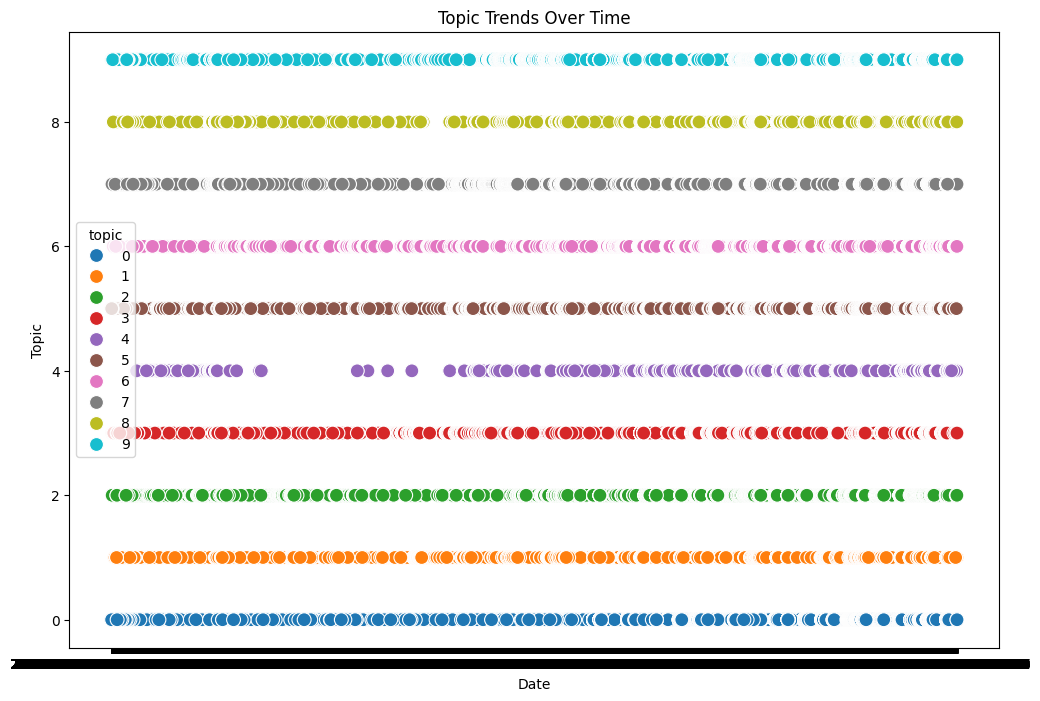

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot topic trends over time
plt.figure(figsize=(12, 8))
sns.scatterplot(x=news_df['published_at'], y=news_df['topic'], hue=news_df['topic'], palette="tab10", s=100)
plt.title("Topic Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Topic")
plt.show()


In [10]:
from sklearn.cluster import KMeans

# Apply K-Means to cluster articles into events
kmeans_model = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans_model.fit_predict(tfidf_matrix_content)

# Assign cluster labels to the articles
news_df['event_cluster'] = kmeans_labels

# Analyze the number of articles per event
event_counts = news_df['event_cluster'].value_counts()
print("Number of articles per event cluster:")
print(event_counts.head(10))


Number of articles per event cluster:
event_cluster
0     47656
4     10462
9      6553
14     5019
6      4570
18     3958
13     3069
17     3043
16     2772
3      2304
Name: count, dtype: int64


In [ ]:
# Find the earliest report date for each event cluster
earliest_report = news_df.groupby('event_cluster')['published_at'].min()

# Find the site that reported each event first
first_reporter = news_df.loc[news_df.groupby('event_cluster')['published_at'].idxmin()]

print("Sites that reported events the earliest:")
print(first_reporter[['event_cluster', 'source_name', 'published_at']].head(10))


In [11]:
# Analyze which events have the highest reporting frequency
most_reported_events = event_counts.sort_values(ascending=False).head(10)
print("Most reported events:")
print(most_reported_events)


Most reported events:
event_cluster
0     47656
4     10462
9      6553
14     5019
6      4570
18     3958
13     3069
17     3043
16     2772
3      2304
Name: count, dtype: int64


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table of event clusters and sources
event_source_matrix = pd.crosstab(news_df['event_cluster'], news_df['source_name'])

# Compute correlation between sites based on event reporting
site_correlation = event_source_matrix.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(site_correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between News Sites Based on Event Reporting")
plt.show()
